# Deep convolution


On va découvrir les réseaux de neurone convolutionnels qui sont très fort pour analyser des signaux (images, sons, vidéos).

Même des images mal dessinées: testez [quick draw](https://quickdraw.withgoogle.com/)



In [2]:
!pip install equinox

In [3]:
%reset -f

In [4]:
import numpy as np
import os
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap, jit, lax
import equinox as eqx

import matplotlib.pyplot as plt
np.set_printoptions(linewidth=500,precision=2,suppress=True)

## Préliminaire: tree_at

In [8]:
# Notre PyTree d'exemple
pytree = [{"a": 1, "b": 2}, {"a": 3, "b": 4}]
pytree

Changer une valeur

In [9]:
# Fonction `where` qui retourne la feuille à modifier
def where_one(tree):
    return tree[0]["a"]   # on cible pytree[0]["a"] qui vaut 1


# On remplace directement par 999
new_pytree_1 = eqx.tree_at(where_one, pytree, replace=999)
new_pytree_1

Changer DEUX valeurs en même temps

In [10]:
# retourne un tuple de deux feuilles
def where_two(tree):
    return (tree[0]["a"], tree[1]["a"])  # les deux valeurs sous la clé "a"

# On fournit un tuple de même longueur pour le remplacement
new_pytree_2 = eqx.tree_at(
    where_two,
    pytree,
    replace=(111, 333)   # 111 remplace le premier "a", 333 le second
)
new_pytree_2

On peut aussi appliquer une fonction (ex: multiplier par 10 les deux "a")

In [11]:
new_pytree_with_replace_fn = eqx.tree_at(
    where_two,
    pytree,
    replace_fn=lambda x: x * 10
)

new_pytree_with_replace_fn

## Les shapes des images et des kernels

### En jax-equinox

En `jax-equinox`  une image est un tenseur `X` de dimension 3:

     X.shape=(img_n_channel, img_height, img_width)


* `img_n_channel`: chaque channel correspond à une "caractérisitique" des pixels. Les images noir et blanc on 1 channel, les images couleurs en ont 3 ou 4 (avec la transparence). Mais les réseaux de neurones convolutif (qu'on va découvrir) créent des images dans leur couche cachées qui peuvent avoir des centaines de channels!  
* `img_height, img_width`: les dimensions des images



Les noyaux de convolutions sont aussi des tenseurs `W` de dimension 4

    W.shape=(n_channel_out, n_channel_in, kernel_height, kernel_width)


Pour que la convolution entre `X` et `W` fonctionne, il faut simplement que le nombre de channel `img_n_channel`=`n_channel_in`. Le résultat `Y=conv(X,W)` (avec l'option `padding=same`) sera un tenseur-image  de shape:

      Y.shape=(n_channel_out, img_height, img_width)


La formule de convolutions est donnée par:

       Y = conv(X,W) [ c , i, j]     =    sum_{di, dj, q}  X[ q,  i + di ,  j + dj] *  W[c, q, di, dj]
      
      

Observons cette formule:


* l'indice `c` n'est pas sommé. Ainsi si `W` à 10 `channels_out`, on effectue simplement 10 convolutions différentes.
* la concolution est faites avec les indices `i,j,di,dj`.
* Observons `q`: La convolution est effectuée en parallèle entre tous les channels de l'image et tous les channel_in du kernel.  Tous les résultats de ces convolutions sont ensuite sommés. Cela crée un beau mélange.




Remarquons que lorsque `kernel_height=kernel_width=1`  on effectue simplement une multiplication matricielle sur les channels.


In [12]:
img_n_channel=3
img_height,img_width=30,30

X=jnp.ones([img_n_channel,img_height,img_width])

n_channel_in=3
assert n_channel_in==img_n_channel
n_channel_out=5

kernel_height,kernel_width = 9,11


layer=eqx.nn.Conv2d(n_channel_in,n_channel_out,(kernel_height,kernel_width),padding="same",key=jr.key(0))

Y=layer(X)

assert Y.shape== (n_channel_out,img_height,img_width)
Y.shape

Observons l'intérieur du layer

In [13]:
params,static=eqx.partition(layer,eqx.is_array)

for p in jax.tree.leaves(params):
    if p is not None:
        print(p.shape)

La première shape correspond bien à celle du kernel:

        (n_channel_out, n_channel_in, kernel_height, kernel_width)

La seconde est clairement un bais qui s'ajoute au résultat final, d'où la shape:

        (n_channel_out, 1, 1)

### Un petit tours par tensorflow et torch

Tensorflow travaille avec la convention 'channel_last' et une dimension de batch, donc les images sont rangées dans des tenseurs:

     X.shape=(batch_size, img_height, img_width, img_n_channel)


Pytorch travaille avec la convention 'channel_first' et  une dimension de batch, donc les images sont rangées dans des tenseurs:

     X.shape=(batch_size, img_n_channel, img_height, img_width)


 Les formats classique des images (jpeg, png) est channel-last, mais sans dimension de batch.


### Lax



La fonction `lax.general_convolution_dilated`  gére tous les formats batchés.


In [14]:
#Pytorch style
lhs = jnp.ones((1, 2, 4, 4))   # (N, C, H, W) → batch, channels, height, width
rhs = jnp.ones((3, 2, 3, 3))   # (O, I, kH, kW) → out_ch, in_ch, kh, kw

result = lax.conv_general_dilated(
    lhs, rhs,
    window_strides=(1, 1),
    padding='VALID',
    dimension_numbers=None  # → ('NCHW', 'OIHW', 'NCHW')
)

print("Sortie shape :", result.shape)  # (1, 3, 2, 2)

In [15]:
#tensorflow style
lhs = jnp.ones((1, 4, 4, 2))   # (N, H, W, C)
rhs = jnp.ones((3, 3, 2, 3))   # (kH, kW, I, O)

result = lax.conv_general_dilated(
    lhs, rhs,
    window_strides=(1, 1),
    padding='VALID',
    dimension_numbers=('NHWC', 'HWIO', 'NHWC')
)

print("Sortie shape :", result.shape)  # (1, 2, 2, 3)

In [16]:
#Keras like
lhs = jnp.ones((1, 2, 4, 4))   # (N, C, H, W)
rhs = jnp.ones((2, 3, 3, 3))   # (I, O, kH, kW) → in_ch, out_ch, kh, kw

result = lax.conv_general_dilated(
    lhs, rhs,
    window_strides=(1, 1),
    padding='VALID',
    dimension_numbers=('NCHW', 'IOHW', 'NCHW')
)

print("Sortie shape :", result.shape)  # (1, 3, 2, 2)

## Observons sur des images

In [17]:
"fonctions utilitaires"
def plot_image(image):

    n_channel,_,_=image.shape

    fig,axs=plt.subplots(1,n_channel,figsize=(2*n_channel,2))
    if n_channel==1:
        axs=[axs]

    for j in range(n_channel):
        axs[j].imshow(image[j,:,:], interpolation="nearest")
        axs[j].set_title(f"channel {j}")
        axs[j].set_xticks([])
        axs[j].set_yticks([])

    fig.tight_layout()

### Plusieurs convolutions d'un coup

In [18]:
from sklearn.datasets import load_sample_image
height, width=220,250
image_np = load_sample_image("china.jpg")[100:100+height, 100:100+width]
image_np.shape

In [19]:
image=jnp.transpose(image_np,[2,0,1])/255
image.shape,image.dtype

⇑ on a maintenant le bon forma 'channel first'

In [20]:
plot_image(image)

In [21]:
"on crée une version en niveaux de gris"
image_gray = jnp.mean(image,axis=0,keepdims=True)
image_gray.shape

In [22]:
plot_image(image_gray)

### Manipulons l'image en niveau de gris

In [23]:
kernel_manual = np.zeros([2,1,11, 11])
kernel_manual[0,0,:, 5] = 1
kernel_manual[1,0,5, :] = 1
kernel_manual=jnp.array(kernel_manual)

In [24]:
fig,(ax0,ax1)=plt.subplots(1,2)
ax0.imshow(kernel_manual[0,0,:,:])
ax1.imshow(kernel_manual[1,0,:,:]);

In [25]:
conv = eqx.nn.Conv2d(
    in_channels=1,
    out_channels=2,
    kernel_size=(11, 11),
    padding="same",
    key=jr.key(0)
)
#Remplacer les poids
conv = eqx.tree_at(lambda c: c.weight, conv, kernel_manual)

In [26]:
Y=conv(image_gray)
Y.shape

In [27]:
plot_image(Y)

⇑ floutage horizontal et vertical comme on s'y attend

### Manipulons le'image couleur

In [28]:
kernel_manual = np.zeros([3,3,1, 1])
kernel_manual[:,:,0,0] = -np.eye(3)
kernel_manual=jnp.array(kernel_manual)

In [29]:
conv = eqx.nn.Conv2d(
    in_channels=3,
    out_channels=3,
    kernel_size=(1, 1),
    padding="same",
    key=jr.key(0)
)
#Remplacer les poids
conv = eqx.tree_at(lambda c: c.weight, conv, kernel_manual)

In [30]:
Y=conv(image)
Y.shape

In [31]:
plot_image(Y)

⇑ on a inverser les 3 channels

### Manipulons les images couleurs 2

In [32]:
kernel_manual = np.zeros([3,3,51,51])
kernel_manual[:,:,-1,-1] = 1
kernel_manual=jnp.array(kernel_manual)
kernel_manual.shape

In [33]:
conv = eqx.nn.Conv2d(
    in_channels=3,
    out_channels=3,
    kernel_size=(51, 51),
    padding="same",
    key=jr.key(0)
)
#Remplacer les poids
conv = eqx.tree_at(lambda c: c.weight, conv, kernel_manual)

In [34]:
Y=conv(image)
Y.shape

In [35]:
plot_image(Y)

⇑ on a translater les 3 images. Comprenez-vous pourquoi ?

## Padding, stride, initialisation

###  padding





Le padding c'est le fait de rajouter des zéros autour de l'image.
* Si on ajoute verticallement `padding_height` pixel
* Si on ajoute horizontallement `padding_width` pixel

La taille de l'image après convolution est:

                    img_out_height =  img_in_height + padding_height - kernel_height  + 1
                    img_out_width  =  img_in_width  + padding_width  - kernel_width   + 1


***A vous:***  Dessinez  sur un papier un cadrillage 10 $\times$ 10 représentant une image. Effectuez la convolution avec un noyau 3$\times$3 en prenant un padding de 0 (`padding=="VALID"`). Vérifiez la *formule générale* (notamment pour comprendre notamment le +1 de la fin).


L'argument padding de `eqx.nn.Conv2d` peut prendre 3 types d'arguments:
* Une paire d'entier indiquant `padding_height,padding_width`
* Un unique entier `padding` qui sera transformé utilisé à la fois pour `padding_height` et  `padding_width`
* Une string qui peut être `"same"` ou `"valid"`, cette dernière option étant la valeur par défaut.







Le mode `valide` correspond simplement à `padding=0`. Le mode `same` s'arrange pour que l'image de sortie ai la même dimension que l'image d'entrée en prenant:

padding_heigh=...

kernel_width=...


Pour être précis, les zéro du padding sont répartis tout autour de l'image. En général on prend des taille de padding impair. Par exemple si `padding_width`=5, on ajoute alors 2 colonnes de zéros à droite de l'image et deux colonnes de zéros à gauche.




***A vous:*** Ajoutez la légende aux animations ci-dessous. Vous avez le choix entre `same`, `valid`, `full`. Ce dernier met le padding 'maximal' pour le la convolution soit intéressante. Mais il n'est pas implémenté en equinox (mais en numpy/scipy, oui).

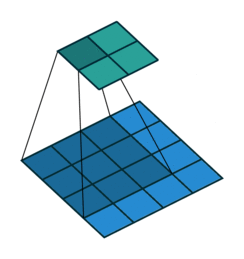

 Ajoutez une légende ...


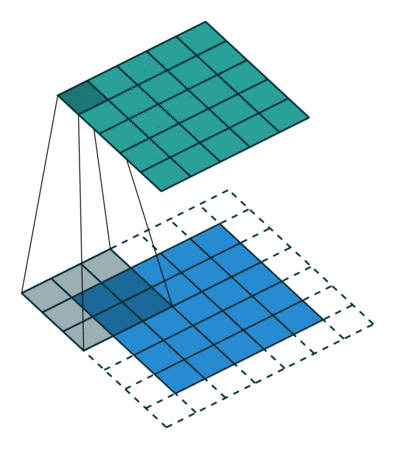

Ajoutez une légende ...




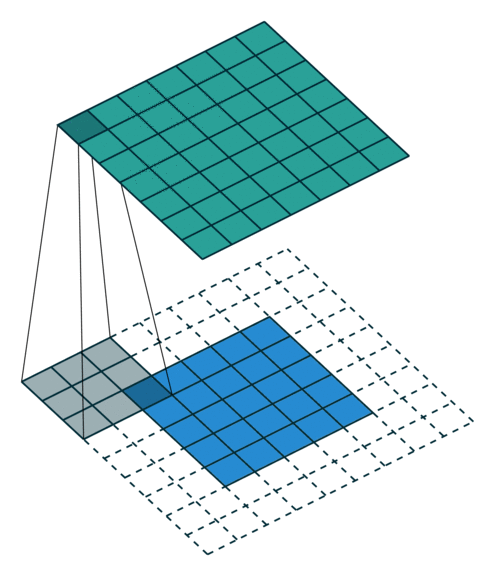

 Ajoutez une légende ...


### Non-zero padding

In [41]:
def my_pad(x,pad_h,pad_w,padding_mode):
    if padding_mode == "zeros":
        x = jnp.pad(x, ((0, 0),(pad_h[0], pad_h[1]), (pad_w[0], pad_w[1])))
    elif padding_mode == "reflect":
        x = jnp.pad(x, ((0, 0),(pad_h[0], pad_h[1]), (pad_w[0], pad_w[1])), mode="reflect")
    elif padding_mode == "replicate":
        x = jnp.pad(x, ((0, 0),(pad_h[0], pad_h[1]), (pad_w[0], pad_w[1])), mode="edge")
    elif padding_mode == "circular":
        x = jnp.pad(x, ((0, 0),(pad_h[0], pad_h[1]), (pad_w[0], pad_w[1])), mode="wrap")
    else:
        assert False
    return x

In [42]:
image.shape

In [45]:
img_pad=my_pad(image,(20,20),(20,20),"replicate")
plot_image(img_pad)

### Stride

Le stride c'est le pas de déplacement du noyau de convolution.
Ainsi avec stride=2, le noyau saute un pixel sur deux. L'image résultante de la convolution est, grosso mode, deux fois plus petite.



Cela peut remplacer le max-pooling (cf plus loin). Certains dise que c'est mieux, d'autre non.



In [ ]:
kernel_height,kernel_width=15,23
for stride in [2,3,4]:
    layer=eqx.nn.Conv2d(3,1,(kernel_height,kernel_width),stride=stride,key=jr.key(0))
    Y=layer(image)
    print(Y.shape)

On peut combiner le stridde et le padding. Ci-dessous des animations avec `stridde=2`.

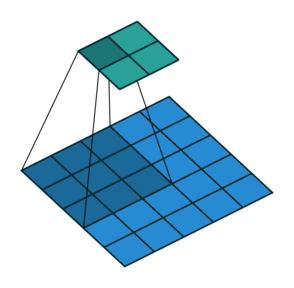

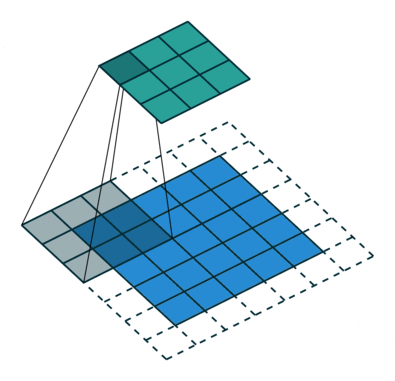

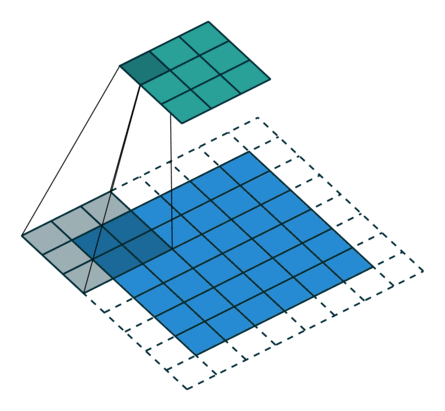

### Dilatation

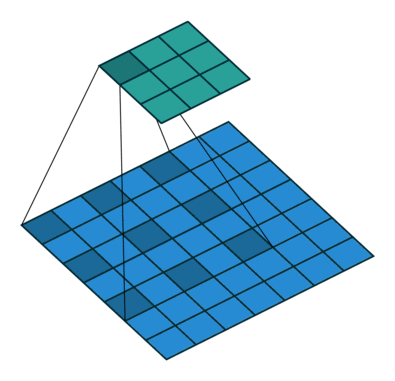

Quand on mélange tous les paramètres, la taille finale se calcul par la formule (tirée de l'aide de torch):

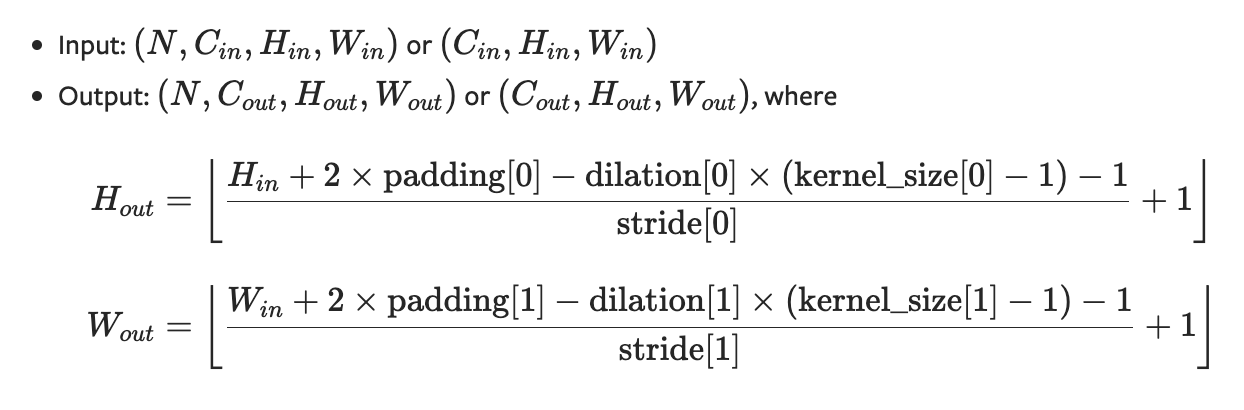

$\lfloor a \rfloor$ représente la partie entière inférieure.

### Initialisation du kernel et du biais

In [ ]:
def default_weight_init(key, shape, dtype):
    # shape = (out_channels, in_channels, *kernel_size)
    fan_in = shape[1] * np.prod(shape[2:])  # in_channels * kernel_area
    std = 1.0 / jnp.sqrt(fan_in)
    return jax.random.truncated_normal(key, -2*std, 2*std, shape, dtype)

Donc :

* Distribution aléatoire: "truncated_normal": un gaussienne  coupée à ±2σ
* Écart-type : `σ=1 / sqrt(fan_in)`
* `fan_in = in_channels × kernel_height × kernel_width`

Cela permet de garder la variance du signal qui tranverse le réseau de neurone constante (tout comme dans les layer `Linear`).

## Max Pooling


### Principe


Quand on fait:

    layer=eqx.nn.MaxPool2d(kernel_size=kernel_size,stride=stride)
    Y=layer(images)

on prend une fenêtre de taille `kernel_size,kernel_size`. On la fait glisser sur l'image exactement comme une convolution, avec un pas égal à `stride` en gardant pour chaque position le maximum de la fenêtre.

Quand on ne précise pas `stride`, par défault il est pris égal à 1. Mais en tensorflow ou torch, par défaut il est égal à `kernel_size` car c'est souvent ainsi qu'on l'utilise.


On peut aussi donner un couples `kernel_size=(kernel_heigt,kernel_with)` si on veut une fenêtre rectangulaire. Et on peut aussi mettre un couple pour l'argument `stride` pour glisser différemment verticalement et horizontalement.


In [ ]:
for kernel_size in [2,3,4,5]:
    layer=eqx.nn.MaxPool2d(kernel_size,stride=kernel_size)
    Y=layer(image)
    print(Y.shape)
    plot_image(Y)
    plt.show()

## Défi prog: Un filtre de Sobel


In [ ]:
#construisons une petite image pour tester
x = np.zeros([28, 28])
x[5:10, 10:20] = 1
plt.imshow(x);

In [ ]:
#on rend l'image de dimension 3
x = x[None,:,:]
x.shape

construisons un noyau qui calcule une dérivée directionnelle horizontale

In [ ]:
W=
W

In [ ]:
#--- To keep following outputs, do not run this cell! ---

Array([[-1.,  0.,  1.],
       [-2.,  0.,  2.],
       [-1.,  0.,  1.]], dtype=float32)

construisons un noyau qui calcule une dérivée directionnelle verticale

In [ ]:
WT=
WT

In [ ]:
#--- To keep following outputs, do not run this cell! ---

Array([[-1., -2., -1.],
       [ 0.,  0.,  0.],
       [ 1.,  2.,  1.]], dtype=float32)

In [ ]:
kernel=jnp.stack([W,WT])[:,None,:,:]
kernel.shape

Créons le layer de convolution:

In [ ]:
layer=eqx.nn.Conv2d(1,2,3,key=jr.key(0),padding="same")

Modifions les poids:

In [ ]:
layer =


Testons ce layer

In [ ]:
Y=layer(x)
Y.shape

In [ ]:
#--- To keep following outputs, do not run this cell! ---

(2, 28, 28)

In [ ]:
plot_image(Y)

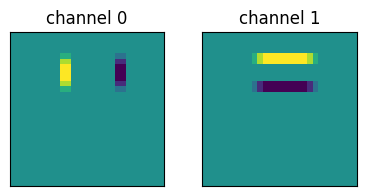

In [ ]:
#--- To keep following outputs, do not run this cell! ---

première tentative: la somme des valeurs absolue des gradients verticaux et horizontaux:

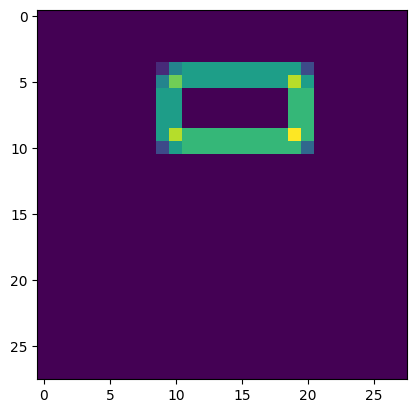

In [ ]:
#--- To keep following outputs, do not run this cell! ---

In [ ]:
border.min(), border.max()

Maintenant on va binariser (ne garder que des 0 et 1 dans l'image).

Test avec un premier seuil:

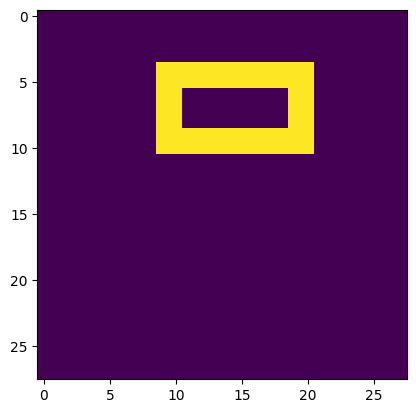

In [ ]:
#--- To keep following outputs, do not run this cell! ---

Test avec un secon seuil.

In [ ]:
border_bin=(border>3).astype(jnp.float32)
plt.imshow(border_bin);

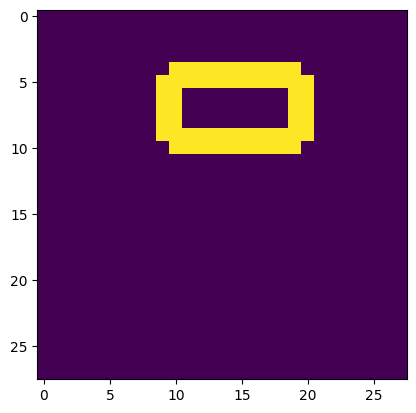

In [ ]:
#--- To keep following outputs, do not run this cell! ---